In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset

# Ustawienia
CONFIG = {
    'data_path': '../data/processed/reports/combined.csv',
    'sequence_length': 10,    # Patrzymy 60 dni wstecz (ok. 3 miesiące)
    'prediction_window': 1,   # Przewidujemy następny dzień
    'hidden_size': 48,       # Rozmiar warstwy ukrytej LSTM
    'num_layers': 2,          # Liczba warstw LSTM
    'dropout': 0.2,           # Zapobieganie przeuczeniu
    'batch_size': 64,
    'epochs': 20,
    'learning_rate': 0.01,
    'train_split': 0.8,       # 80% danych na trening (chronologicznie)
    'commission': 0.0010,     # 0.10% prowizji (kupno + sprzedaż = x2 w backteście)
    'buy_threshold': 0.0     # Model musi być w 60% pewny, żeby kupić
}

# Sprawdzenie GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Używam urządzenia: {device}")

Używam urządzenia: cuda


In [13]:
def calculate_technical_indicators(df):
    """Tworzy wskaźniki niezależne od ceny nominalnej."""
    df = df.copy()

    # 1. Log Return (Logarytmiczna stopa zwrotu - lepsza dla modeli ML)
    # Dodajemy małą stałą, aby uniknąć log(0)
    df['close'] = df['close'].replace(0, method='ffill')
    df['log_ret'] = np.log(df['close'] / df['close'].shift(1))

    # 2. RSI (Relative Strength Index)
    window = 14
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi_norm'] = df['rsi'] / 100.0  # Skalowanie 0-1

    # 3. Zmienność (Volatility) - odchylenie standardowe zwrotów
    df['volatility'] = df['log_ret'].rolling(window=20).std()

    # 4. Relacja ceny do SMA (Simple Moving Average) 50 dni
    # Mówi nam, czy cena jest "droga" czy "tania" względem średniej
    df['sma50'] = df['close'].rolling(window=50).mean()
    df['dist_sma50'] = (df['close'] - df['sma50']) / df['sma50']

    # 5. Wolumen relatywny (czy dzisiaj handlują więcej niż zwykle?)
    df['vol_ma'] = df['volume'].rolling(window=20).mean()
    df['vol_rel'] = df['volume'] / (df['vol_ma'] + 1e-9) # unikanie dzielenia przez 0

    # TARGET: 1 jeśli cena jutro wzrośnie, 0 jeśli spadnie/bez zmian
    df['target_return'] = df['close'].shift(-1) / df['close'] - 1
    df['target'] = (df['target_return'] > 0).astype(float)

    return df

print("Ładowanie danych...")
raw_df = pd.read_csv(CONFIG['data_path'])

# Konwersja daty
raw_df['date'] = pd.to_datetime(raw_df['date'])

# Sortowanie danych (krytyczne dla Time Series!)
raw_df = raw_df.sort_values(['symbol', 'date'])

# Filtrowanie błędnych danych (abnormal gaps)
print(f"Liczba wierszy przed filtrowaniem: {len(raw_df)}")
raw_df = raw_df[raw_df['flag_abnormal_gap'] == 0]

# Aplikowanie wskaźników dla każdej spółki osobno
processed_list = []
for symbol, group in raw_df.groupby('symbol'):
    # Musimy mieć minimum danych, żeby policzyć wskaźniki (np. 50 dni dla SMA)
    if len(group) > 60:
        processed_group = calculate_technical_indicators(group)
        processed_list.append(processed_group)

df_full = pd.concat(processed_list)
df_full.dropna(inplace=True) # Usuwamy NaN powstałe przy liczeniu wskaźników

print(f"Liczba wierszy po procesingu: {len(df_full)}")
print("Dostępne kolumny:", df_full.columns.tolist())

# Wybór cech do treningu
FEATURES = ['log_ret', 'rsi_norm', 'volatility', 'dist_sma50', 'vol_rel']
print(f"Cechy użyte do modelu: {FEATURES}")

Ładowanie danych...
Liczba wierszy przed filtrowaniem: 37997
Liczba wierszy po procesingu: 36476
Dostępne kolumny: ['symbol', 'date', 'open', 'high', 'low', 'close', 'volume', 'ret_1d', 'flag_abnormal_gap', 'log_ret', 'rsi', 'rsi_norm', 'volatility', 'sma50', 'dist_sma50', 'vol_ma', 'vol_rel', 'target_return', 'target']
Cechy użyte do modelu: ['log_ret', 'rsi_norm', 'volatility', 'dist_sma50', 'vol_rel']


/tmp/ipykernel_15950/3220947172.py:7: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['close'] = df['close'].replace(0, method='ffill')
/tmp/ipykernel_15950/3220947172.py:7: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['close'] = df['close'].replace(0, method='ffill')
/tmp/ipykernel_15950/3220947172.py:7: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['close'] = df['close'].replace(0, method='ffill')
/tmp/ipykernel_15950/3220947172.py:7: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['close'] = df['close'].replace(0, method='ffill')
/tmp/ipykernel_15950/3220947172.py:7: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['close'] = df['close'].replace(0, method

In [14]:
# --- KOMÓRKA 3: GENEROWANIE SEKWENCJI ---

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_sequences_by_group(df, seq_length, features):
    """
    Tworzy sekwencje osobno dla każdej spółki, żeby nie łączyć 
    końca danych KGHM z początkiem danych PKO.
    """
    X_list, y_list, meta_list = [], [], []

    # Skalowanie danych - fitujemy na WSZYSTKICH danych (uproszczenie dla przykładu)
    # W super ścisłym podejściu fituje się tylko na train, ale tutaj normalizujemy wskaźniki
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[features] = scaler.fit_transform(df[features])

    for symbol, group in df_scaled.groupby('symbol'):
        data = group[features].values
        targets = group['target'].values
        dates = group['date'].values
        returns = group['target_return'].values # potrzebne do backtestu

        for i in range(len(data) - seq_length):
            X_list.append(data[i:(i+seq_length)])
            y_list.append(targets[i+seq_length-1]) # target następnego dnia po sekwencji

            # Zapisujemy metadane do backtestu (data, symbol, rzeczywisty zwrot)
            meta_list.append({
                'date': dates[i+seq_length-1],
                'symbol': symbol,
                'actual_return': returns[i+seq_length-1]
            })

    return np.array(X_list), np.array(y_list), pd.DataFrame(meta_list)

# Podział chronologiczny na Train/Test
dates = df_full['date'].sort_values().unique()
split_idx = int(len(dates) * CONFIG['train_split'])
split_date = dates[split_idx]

print(f"Data podziału Train/Test: {split_date}")

train_df = df_full[df_full['date'] < split_date]
test_df = df_full[df_full['date'] >= split_date]

print("Generowanie sekwencji treningowych...")
X_train, y_train, _ = create_sequences_by_group(train_df, CONFIG['sequence_length'], FEATURES)

print("Generowanie sekwencji testowych...")
X_test, y_test, meta_test = create_sequences_by_group(test_df, CONFIG['sequence_length'], FEATURES)

print(f"Kształt X_train: {X_train.shape}")
print(f"Kształt X_test: {X_test.shape}")

train_loader = DataLoader(StockDataset(X_train, y_train), batch_size=CONFIG['batch_size'], shuffle=True)
test_loader = DataLoader(StockDataset(X_test, y_test), batch_size=CONFIG['batch_size'], shuffle=False)

Data podziału Train/Test: 2023-09-20 00:00:00
Generowanie sekwencji treningowych...
Generowanie sekwencji testowych...
Kształt X_train: (29031, 10, 5)
Kształt X_test: (7165, 10, 5)


In [15]:
# --- KOMÓRKA 4: DEFINICJA MODELU ---

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Warstwy w pełni połączone na końcu
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid() # Wyjście 0-1
        )

    def forward(self, x):
        # Inicjalizacja stanów ukrytych
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # LSTM forward
        # out: (batch_size, seq_len, hidden_size)
        out, _ = self.lstm(x, (h0, c0))

        # Bierzemy wyjście tylko z ostatniego kroku czasowego (ostatni dzień sekwencji)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = LSTMClassifier(
    input_dim=len(FEATURES),
    hidden_dim=CONFIG['hidden_size'],
    num_layers=CONFIG['num_layers'],
    dropout=CONFIG['dropout']
).to(device)

optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
criterion = nn.BCELoss() # Binary Cross Entropy dla klasyfikacji

Rozpoczynam trening...
Epoch [2/20], Loss: 0.6918
Epoch [4/20], Loss: 0.6919
Epoch [6/20], Loss: 0.6916
Epoch [8/20], Loss: 0.6913
Epoch [10/20], Loss: 0.6914
Epoch [12/20], Loss: 0.6910
Epoch [14/20], Loss: 0.6911
Epoch [16/20], Loss: 0.6912
Epoch [18/20], Loss: 0.6914
Epoch [20/20], Loss: 0.6912


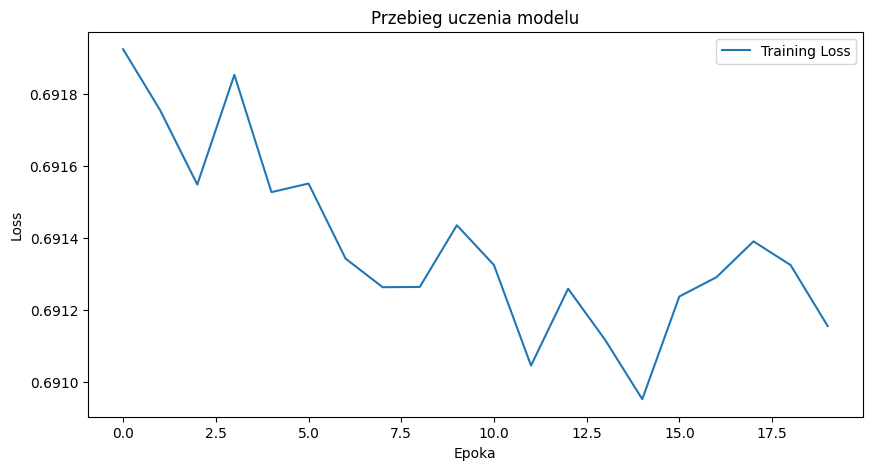

In [16]:
# --- KOMÓRKA 5: TRENING ---

loss_history = []

print("Rozpoczynam trening...")
for epoch in range(CONFIG['epochs']):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)

    if (epoch + 1) % 2 == 0:
        print(f"Epoch [{epoch+1}/{CONFIG['epochs']}], Loss: {avg_loss:.4f}")

# Wykres straty
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Przebieg uczenia modelu')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.legend()
plt.show()

--- WYNIKI BACKTESTU (Threshold: 0.65) ---
Liczba transakcji: 13
Win Rate: 61.54%
Skumulowany zwrot (suma %): 0.3694


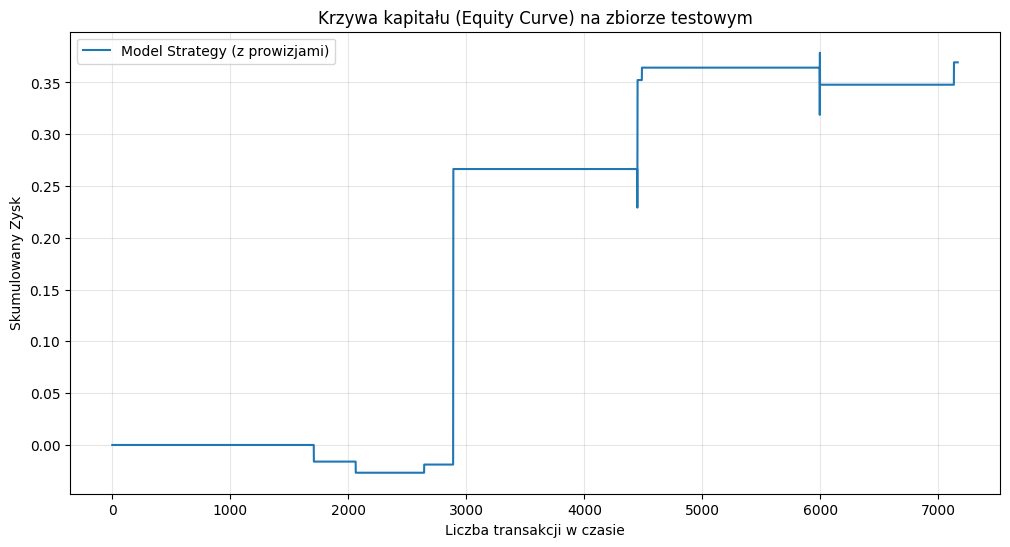


Top 5 spółek z najlepszym wynikiem wg modelu:
symbol
ker    0.293190
peo    0.097883
tpe    0.021597
brs    0.000000
bhw    0.000000
Name: strategy_return, dtype: float64


In [25]:
# --- KOMÓRKA 6: BACKTEST I OCENA ---

model.eval()
predictions = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).cpu().numpy()
        predictions.extend(preds.flatten())

# Dołączamy predykcje do metadanych testowych
meta_test['prob_up'] = predictions
meta_test['prediction'] = (meta_test['prob_up'] > CONFIG['buy_threshold']).astype(int)

# --- LOGIKA TRADINGOWA ---
# Strategia: Kupujemy na otwarciu następnego dnia, sprzedajemy na zamknięciu (1 day hold).
# Prowizja naliczana jest przy wejściu i wyjściu (2x commission).

# Obliczamy wynik transakcji (PnL)
# Jeśli prediction == 1, nasz wynik to (rzeczywisty zwrot - 2*prowizja)
# Jeśli prediction == 0, nie robimy nic (wynik 0)
# Zakładamy prowizję od całej wartości pozycji.

meta_test['strategy_return'] = meta_test.apply(
    lambda row: (row['actual_return'] - 2 * CONFIG['commission']) if row['prediction'] == 1 else 0,
    axis=1
)

# Statystyki
total_trades = meta_test['prediction'].sum()
win_trades = meta_test[(meta_test['prediction'] == 1) & (meta_test['actual_return'] > 0)].shape[0]
win_rate = win_trades / total_trades if total_trades > 0 else 0

print(f"--- WYNIKI BACKTESTU (Threshold: {CONFIG['buy_threshold']}) ---")
print(f"Liczba transakcji: {total_trades}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Skumulowany zwrot (suma %): {meta_test['strategy_return'].sum():.4f}")

# Krzywa kapitału
meta_test['cumulative_return'] = meta_test['strategy_return'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(meta_test['cumulative_return'].values, label='Model Strategy (z prowizjami)')
plt.title('Krzywa kapitału (Equity Curve) na zbiorze testowym')
plt.xlabel('Liczba transakcji w czasie')
plt.ylabel('Skumulowany Zysk')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Sprawdzenie dla konkretnych spółek
print("\nTop 5 spółek z najlepszym wynikiem wg modelu:")
print(meta_test.groupby('symbol')['strategy_return'].sum().sort_values(ascending=False).head(5))